In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import pytz
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
Root = 'C:/FishIsland_2017/'

In [3]:
Flux_Path_10_aut = Root+'FluxResults/FullDataSet/eddypro_FishIsland_UstarFill2_2017-09-15T071111_adv.csv'
# Flux_Path_10_aut = Root+'FluxResults/WindFix/eddypro_Test_full_output_2018-02-07T115755_adv.csv'
# Flux_Path_10_aut = Root+'FluxResults/WindFix/Test/eddypro_10Hz_full_output_2018-02-13T154151_adv.csv'
Flux_Path_1_aut = Root+'FluxResults/AutoLag/1Hz/eddypro_Test_full_output_2017-08-13T160956_adv.csv'
# Flux_Path_1_aut = Root+'FluxResults/WindFix/eddypro_1Hz_full_output_2018-02-12T155926_exp.csv'

Flux_Path_Fill = Root+'FluxResults/FullDataSet/eddypro_FishIsland_UstarFill_2017-09-15T071111_adv.csv'
Met_Path = Root+'MetStationData/CR1000_ClimateData_Updated.txt'
Soil_Path = Root+'SoilStationData/Soil_Data.csv'



In [4]:
class Compile:
    def __init__(self,Flux_Paths,Met,Soil,Suffix = None):
        Flux_10 = self.Format(pd.read_csv(Flux_Paths[0],delimiter = ',',skiprows = 0,parse_dates={'datetime':[1,2]},header = 1,na_values = -9999),v=1,drop = [0,1])
        Flux_1 = self.Format(pd.read_csv(Flux_Paths[1],delimiter = ',',skiprows = 0,parse_dates={'datetime':[1,2]},header = 1,na_values = -9999),v=1,drop = [0,1])
        Flux_Fill = self.Format(pd.read_csv(Flux_Paths[2],delimiter = ',',skiprows = 0,parse_dates={'datetime':[1,2]},header = 1,na_values = -9999),v=1,drop = [0,1])
        Flux_10.fillna(Flux_Fill)
        Flux_10['Hz']=10
        Flux_1['Hz'] = 1
        Flux = Flux_1.append(Flux_10)
        Met = self.Format(pd.read_csv(Met,delimiter = ',',skiprows = 1,parse_dates={'datetime':[0]},header = 0),v=2,drop = [0])
        Soil = self.Format(pd.read_csv(Soil,delimiter = ',',skiprows = 0,parse_dates={'datetime':[0]},header = 0),v=0,drop = [0])

        self.Data = pd.concat([Flux,Met,Soil],axis = 1, join = 'outer')
        self.Data['Minute'] = self.Data.index.hour*60+self.Data.index.minute
        self.Wind_Bins(30)
        self.PPFD_Bins(100)
        self.Data['Day'] = np.floor(self.Data['DOY'])
        
        eastern = pytz.timezone('US/Mountain')
        self.Data['UTC'] = self.Data.index.tz_localize(pytz.utc).tz_convert(eastern)

    def Format(self,df,v,drop):
        df = df.ix[v:]
        df = df.set_index(pd.DatetimeIndex(df.datetime))
        df = df.drop(df.columns[drop],axis=1)
        df = df.astype(float)
        return(df)

    def Wind_Bins(self,Bins):
        self.bins = np.arange(0,360.1,Bins)
        self.Data['Dir'] = pd.cut(self.Data['wind_dir'],bins=self.bins,labels = (self.bins[0:-1]+self.bins[1:])/2)

    def PPFD_Bins(self,Bins):
        self.bins = np.arange(0,self.Data['PPFD_Avg'].max()+1,Bins)
        self.Data['Photon_Flux'] = pd.cut(self.Data['PPFD_Avg'],bins=self.bins,labels = (self.bins[0:-1]+self.bins[1:])/2)

In [5]:
class Process:
    def __init__(self,Data,qc_thresh=None,rain_thresh=None,ch4_signal_thresh=None,spike_thresh=None,wind_drop=None,U_thresh=None):
        self.Fluxes = ['H','LE','co2_flux','ch4_flux']
        self.Data = Data
#         self.Date_Drop('2017-06-23 15:00:00')
        if qc_thresh!=None:
            self.QC_Check(qc_thresh)
        if wind_drop!=None:
            self.Wind_Filter(wind_drop)
        if U_thresh!=None:
            self.Ustar_Check(U_thresh)
        if rain_thresh!=None:
            self.Rain_Check(rain_thresh)
        if ch4_signal_thresh!=None:
            self.Signal_Check(ch4_signal_thresh)
        if spike_thresh!=None:
            self.Spike_Removal(spike_thresh)
        self.NAN_Check()

    def Date_Drop(self,Date):
        self.Data = self.Data.drop(self.Data[self.Data.index<Date].index)
    
    def QC_Check(self,thresh):
        for var in self.Fluxes:
            self.Data[var+'_drop'] = 0
            self.Data.loc[self.Data['qc_'+var]>=thresh,[var,var+'_drop']]=[np.nan,1]
            
    def Wind_Filter(self,width):
        for var in self.Fluxes:
            self.Data.loc[((self.Data['wind_dir']>215-width)&(self.Data['wind_dir']<215+width)),[var,var+'_drop']]=[np.nan,1]
        
        
    def Ustar_Check(self,U_thresh):
        for var in self.Fluxes:
            self.Data.loc[self.Data['u*']<U_thresh,[var,var+'_drop']]=[np.nan,1]
        
    def Rain_Check(self,thresh):
        self.Data['Rain_diff'] = self.Data['Rain_mm_Tot'].diff()
        for var in self.Fluxes:
            if var!='ch4_flux':
                self.Data.loc[self.Data['Rain_mm_Tot']>thresh[0],[var,var+'_drop']]=[np.nan,1]
            else:
                self.Data.loc[self.Data['Rain_mm_Tot']>thresh[1],[var,var+'_drop']]=[np.nan,1]
#            self.Data.loc[self.Data['Rain_diff']<thresh,[var,var+'_drop']]=[np.nan,1]
            
    def Signal_Check(self,thresh):
        self.Data['ch4_noSSFilter'] = self.Data['ch4_flux']
        self.Data.loc[self.Data['rssi_77_mean']<thresh,['ch4_flux','ch4_flux_drop']] = [np.nan,1]
                              
    def Spike_Removal(self,z_thresh):
        for var in self.Fluxes:
            series = self.Data[var].dropna()
            di1 = series.diff()
            di1[:-1] = di1[1:]
            di = di1.diff()
            MD = di.median()
            MAD = np.abs(di-MD).median()
            F1 = di<MD-(z_thresh*MAD/0.6745)
            F2 = di>MD+(z_thresh*MAD/0.6745)
            series.loc[F1==True]=np.nan
            series.loc[F2==True]=np.nan
            Droppers = series.index[np.isnan(series)==True]
            VAR = self.Data[var]
            VAR.ix[Droppers] = np.nan
            dina = VAR.diff()
            dina[:-1] = dina[1:]
            dina2 = VAR.diff()
            NaMid = VAR.index[((np.isnan(dina)==True)&(np.isnan(dina2)==True))]
            VAR.ix[NaMid] = np.nan
            self.Data[var] = VAR
                     
    def NAN_Check(self):
        for var in self.Fluxes:
            self.Data.loc[np.isnan(self.Data[var]) == True,[var+'_drop']]=1

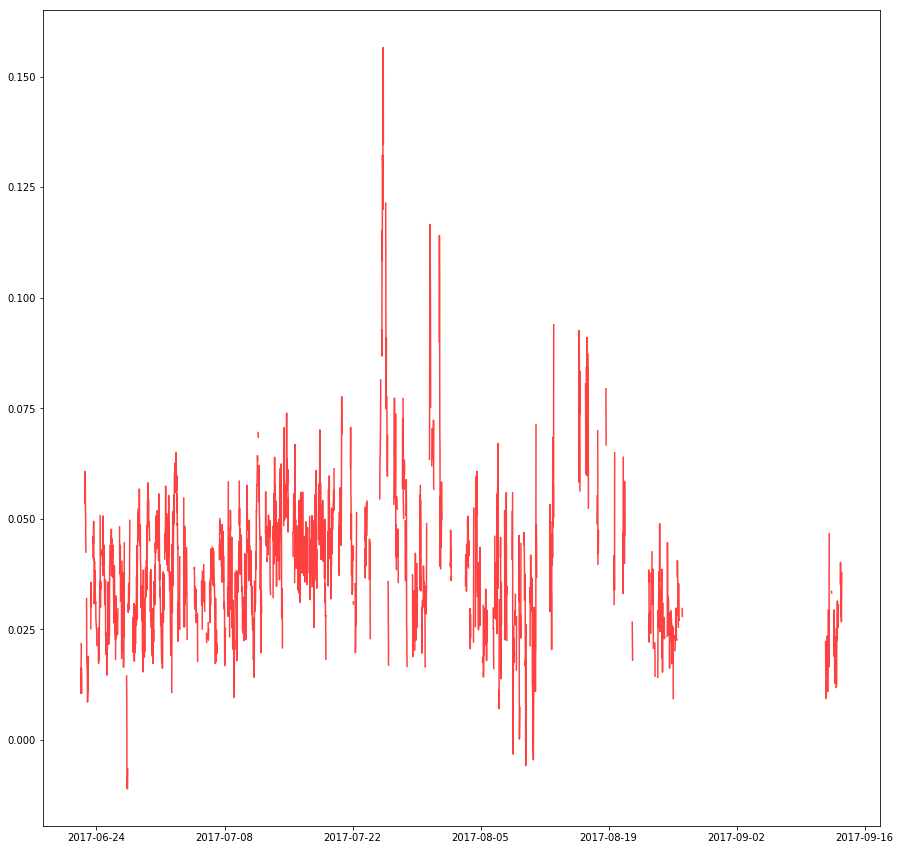

In [6]:
LightGrey = (0,0,0,.75)
Red = (1,0,0,.75)

Comp = Compile([Flux_Path_10_aut,Flux_Path_1_aut,Flux_Path_Fill],Met_Path,Soil_Path,'Cov')
Data = Comp.Data

plt.figure(figsize=(15,15))
# plt.scatter(Data['ch4_flux'].index,Data['ch4_flux'],color = LightGrey)



Proc = Process(Data,qc_thresh=2,rain_thresh=[.5,0],ch4_signal_thresh=10,spike_thresh=4,wind_drop = 30,U_thresh=.1)
Data = Proc.Data

plt.plot(Data['ch4_flux'],color = Red)


10.655439869445132


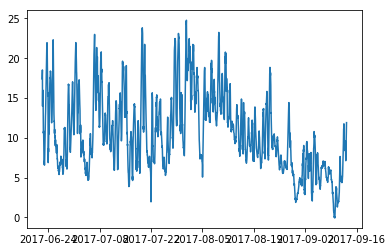

In [10]:
plt.figure()
plt.plot(Data['UTC'],Data['AirTC_Avg'])
Data = Data.ffill()
print(Data['AirTC_Avg'].mean())
plt.show()
# print(Data)

In [8]:
# Data.to_csv('FI_Data.csv')

In [9]:
print(Data['Rain_mm_Tot'].sum())

101.19999999999963
